# Example for training to produce Oxford spikes

## The problem:
From a Poisson spike input, train a multilayer SNN to produce spike raster that resembles Oxford house.
The input and output both consists of 200 neurons each and the spkes span approximately 1900ms.

__Input Spike Raster:__
![](oxford/input.png)

__Desired Spike Raster:__
![](oxford/output.png)

## Load proper paths for SLAYER Pytorch source modules

In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../src")

## Load required modules

SLAYER modules are available as `snn`
* The `spike-layer` module will be available as `snn.layer`.
* The `yaml-parameter` module will be availabe as `snn.params`.
* The `spike-loss` module will be available as `snn.loss`.
* The `spike-classifier` module will be available as `snn.predict`.
* The `spike-IO` module will be available as `snn.io`.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import slayerSNN as snn

## Read SNN configuration from yaml file
See the file for all the configuration parameters. This configuration file will be used to describe the SNN.

In [3]:
netParams = snn.params("oxford/oxford.yaml")

Ts   = netParams['simulation']['Ts']
Ns   = int(netParams['simulation']['tSample'] / netParams['simulation']['Ts'])
Nin  = int(netParams['layer'][0]['dim'])
Nhid = int(netParams['layer'][1]['dim'])
Nout = int(netParams['layer'][2]['dim'])

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules.

In [4]:
class Network(torch.nn.Module):
	def __init__(self, netParams):
		super(Network, self).__init__()
		# initialize slayer
		slayer = snn.layer(netParams['neuron'], netParams['simulation'])
		self.slayer = slayer
		# define network functions
		self.fc1   = slayer.dense(Nin, Nhid)
		self.fc2   = slayer.dense(Nhid, Nout)
        
	def forward(self, spikeInput):
		spikeLayer1 = self.slayer.spike(self.fc1(self.slayer.psp(spikeInput)))
		spikeLayer2 = self.slayer.spike(self.fc2(self.slayer.psp(spikeLayer1)))
		return spikeLayer2


## Initialize the network

In [5]:
# define the cuda device to run the code on
device = torch.device('cuda')

# create a network instance
net = Network(netParams).to(device)

# create snn loss instance
error = snn.loss(netParams).to(device)

# define optimizer module
# optimizer = torch.optim.SGD(snn.parameters(), lr = 0.001)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

## Read input and desired spikes from file
* `snn.io.read1Dspikes` reads from binary spike file with no spatial layout into spike event.
* `snn.io.event.toSpikeTensor` loads spike event into passed tensor at defined sampling time.

The spike tensor is reshaped into proper tensor dimension to be processed by SLAYER PyTorch.
* The tensor follows NCHWT layout. It is recommended to put the neurons in channed dimension if they do not have spatial orientation.

In [6]:
# Read input spikes and load it to torch tensor
inTD  = snn.io.read1Dspikes('oxford/input.bs1')
input = inTD.toSpikeTensor(torch.zeros((1, 1, Nin, Ns)), samplingTime=Ts).reshape((1, Nin, 1, 1, Ns)).to(device)

# Read desired spikes and load it to torch tensor
desTD   = snn.io.read1Dspikes('oxford/output.bs1')
desired = desTD.toSpikeTensor(torch.zeros((1, 1, Nout, Ns)), samplingTime=Ts).reshape((1, Nout, 1, 1, Ns)).to(device)

## Visualize the spike data

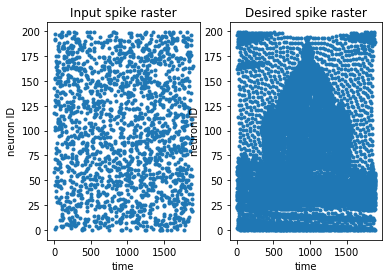

In [7]:
# showTD animation does not work in jupyter session
# snn.io.showTD(snn.io.spikeArrayToEvent(  input.reshape((1, Nin , -1)).cpu().data.numpy()))
# snn.io.showTD(snn.io.spikeArrayToEvent(desired.reshape((1, Nout, -1)).cpu().data.numpy()))
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(inTD.t, inTD.x, '.')
plt.title('Input spike raster')
plt.xlabel('time')
plt.ylabel('neuron ID')

plt.subplot(1, 2, 2)
plt.plot(desTD.t, desTD.x, '.')
plt.title('Desired spike raster')
plt.xlabel('time')
plt.ylabel('neuron ID')
plt.show()


# Run the network
* Run the network for 10000 epochs
* `bestNetwork` is stored for inferencing later

In [8]:
losslog = list()

for epoch in range(10000):
	output = net.forward(input)
	
	loss = error.spikeTime(output, desired)
	
	if epoch%500 == 0:	print('loss in epoch', epoch, ':', loss.cpu().data.numpy())
	losslog.append(loss.cpu().data.numpy())

	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	if epoch==0:
		minLoss = loss
		bestNet = net
	else:
		if loss < minLoss:
			minLoss = loss
			bestNet = net

	if loss < 1e-5:	break

loss in epoch 0 : 223909.14
loss in epoch 500 : 106961.52
loss in epoch 1000 : 96986.695
loss in epoch 1500 : 91070.8
loss in epoch 2000 : 72184.98
loss in epoch 2500 : 67728.586
loss in epoch 3000 : 69248.48
loss in epoch 3500 : 69381.33
loss in epoch 4000 : 57409.355
loss in epoch 4500 : 61283.344
loss in epoch 5000 : 52430.766
loss in epoch 5500 : 47877.96
loss in epoch 6000 : 47008.176
loss in epoch 6500 : 48559.74
loss in epoch 7000 : 43256.24
loss in epoch 7500 : 46419.953
loss in epoch 8000 : 38783.11
loss in epoch 8500 : 43822.59
loss in epoch 9000 : 39055.81
loss in epoch 9500 : 39514.484


## Inference using the best network

In [9]:
output = bestNet.forward(input)

## Plot the Results

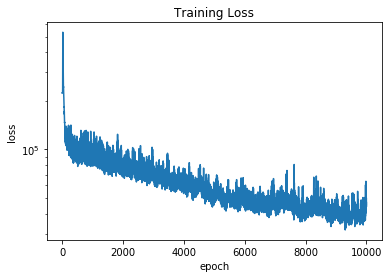

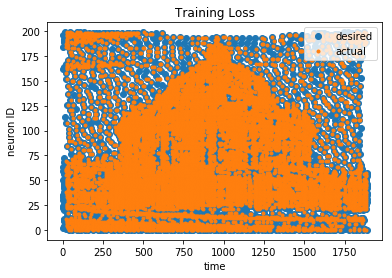

In [10]:
plt.figure(1)
plt.semilogy(losslog)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure(2)
desAER = np.argwhere(desired.reshape((Nout, Ns)).cpu().data.numpy() > 0)
outAER = np.argwhere(output.reshape((Nout, Ns)).cpu().data.numpy() > 0)
plt.plot(desAER[:, 1], desAER[:, 0], 'o', label='desired')
plt.plot(outAER[:, 1], outAER[:, 0], '.', label='actual')
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('neuron ID')
plt.legend()

plt.show()